# Imports

In [34]:
import numpy as np
from Fit import Fit
from funcs import *
from stats import *
import scienceplots
plt.style.use(['grid'])

# Funcs

In [67]:
def G_R(w, R, R_L, L, C):
    return R / np.sqrt( (R+R_L)**2 + np.power(w*L - 1/(w*C), 2) )

def fase_R(w, R, R_L, L, C):
    return -np.arctan( (w*L - 1/(w*C)) / (R+R_L) )

def G(w, R, R_L, L, C):
    num = np.sqrt( np.power( R*R_L + R_L**2 + np.power(w*L - 1/(w*C), 2) , 2) + R*R*(w*L - 1/(w*C)))
    return num / (np.power(R+R_L, 2) + np.power(w*L - 1 /(w*C), 2))

def fase(w, R, R_L, L, C, a):
    return a*np.arctan( R*(w*L - 1/(w*C)) / (R*R_L + R_L**2 + np.power(w*L - 1/(w*C), 2)))

# RLC

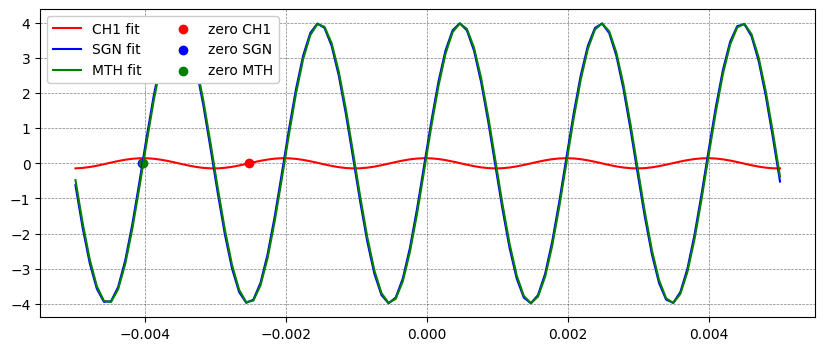

500 0.0015117199999910222 1.1649999999930813e-05


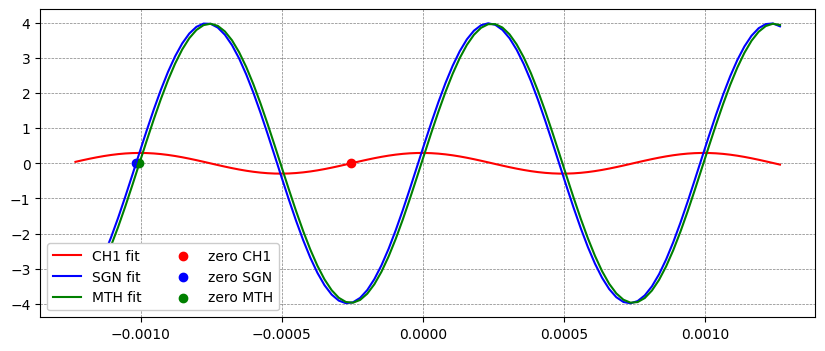

1000 0.0007626900000020328 1.1779999999930041e-05


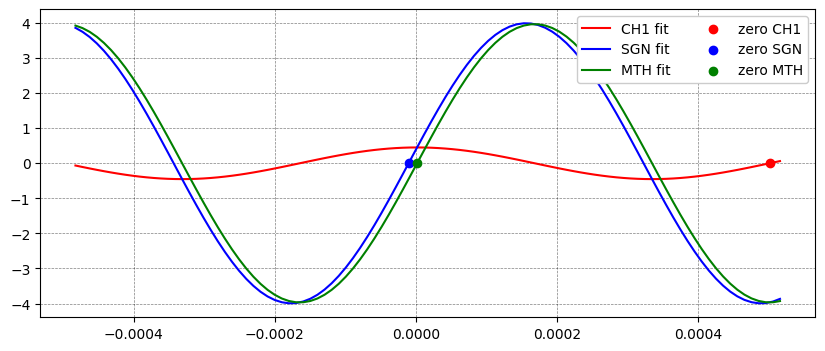

1500 0.0005119499999998514 1.2009999999999905e-05


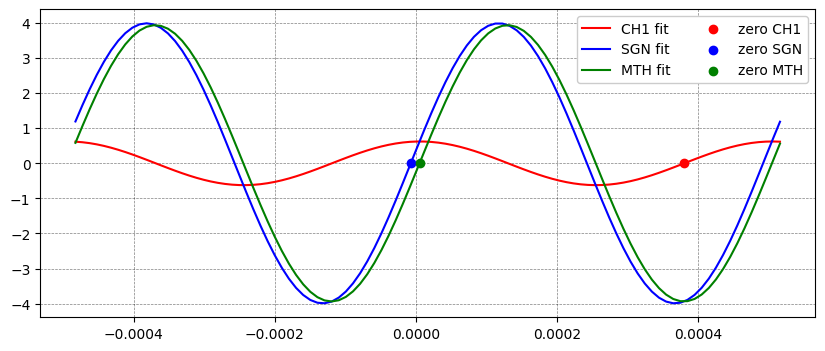

2000 0.0003877799999998417 1.2439999999999901e-05


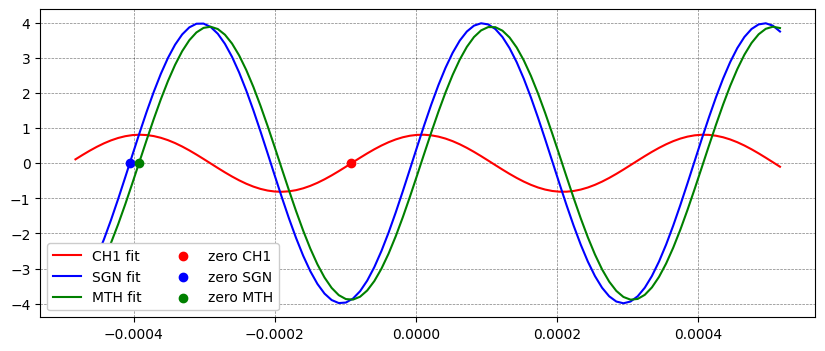

2500 0.00031431999999983725 1.3069999999993232e-05


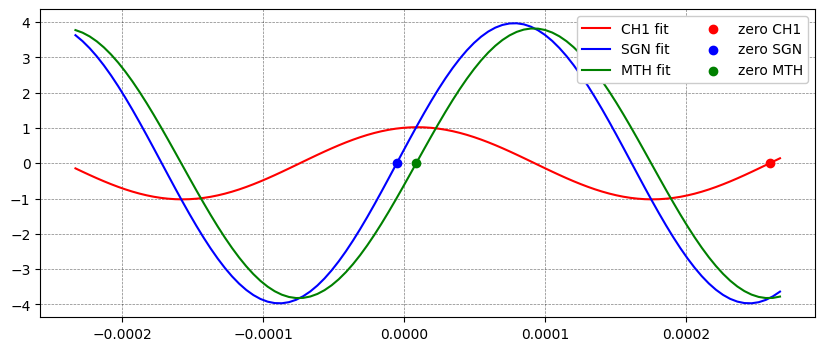

3000 0.00026440999999990456 1.3809999999999888e-05


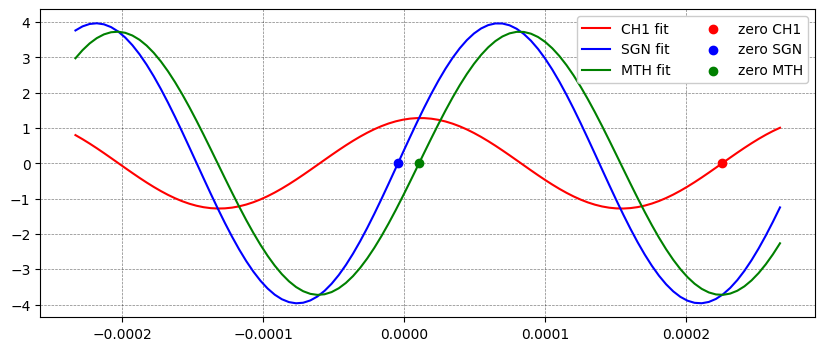

3500 0.00022988999999992195 1.4939999999999877e-05


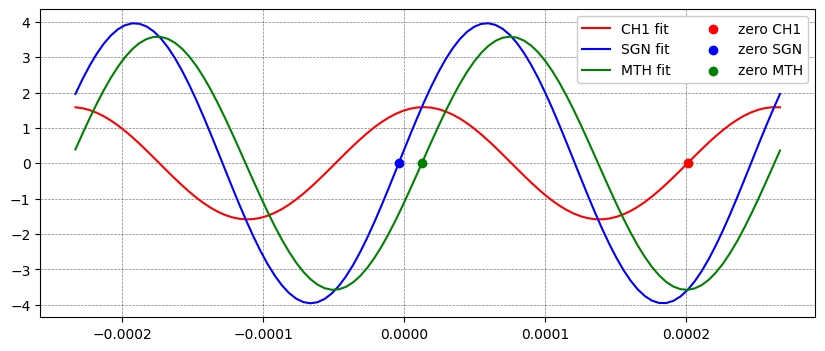

4000 0.00020480999999993466 1.6389999999999862e-05


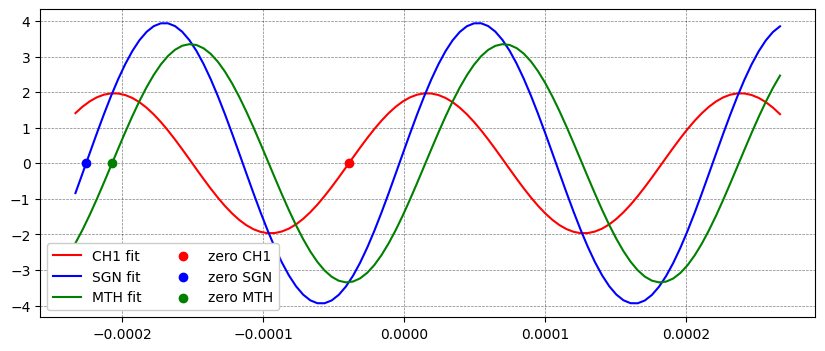

4500 0.00018631999999991838 1.8379999999990483e-05


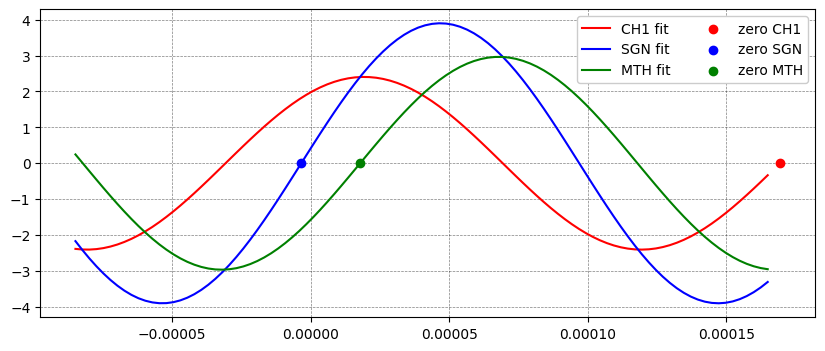

5000 0.00017273999999995108 2.124000000000025e-05


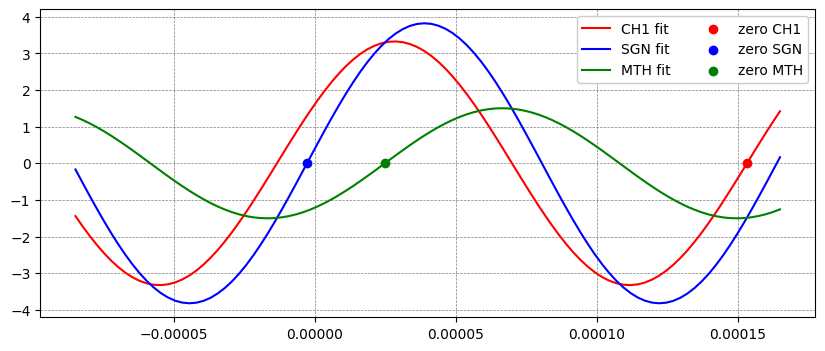

6000 0.00015598999999995945 2.762000000000138e-05


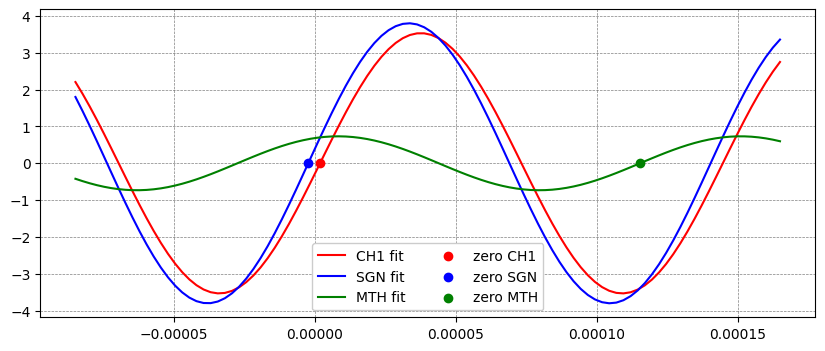

7000 4.18999999999998e-06 0.00011762999999997909


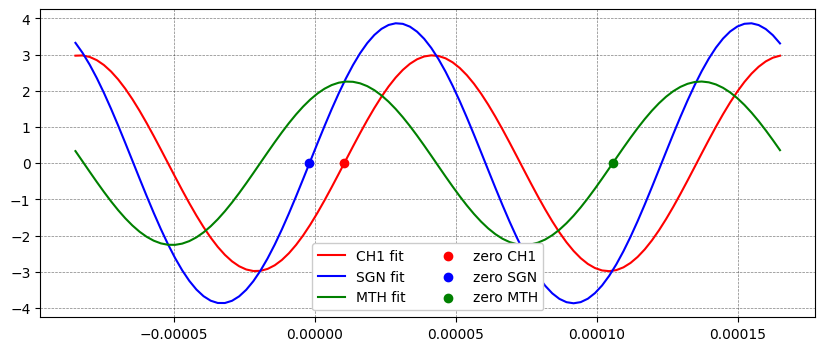

8000 1.2329999999999902e-05 0.0001075199999999841


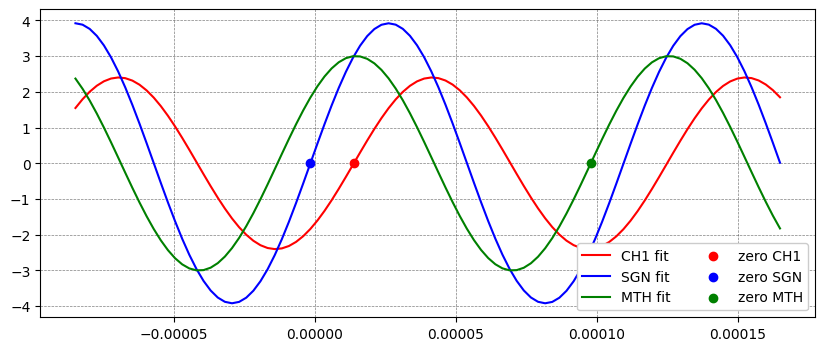

9000 1.5399999999999873e-05 9.940999999998813e-05


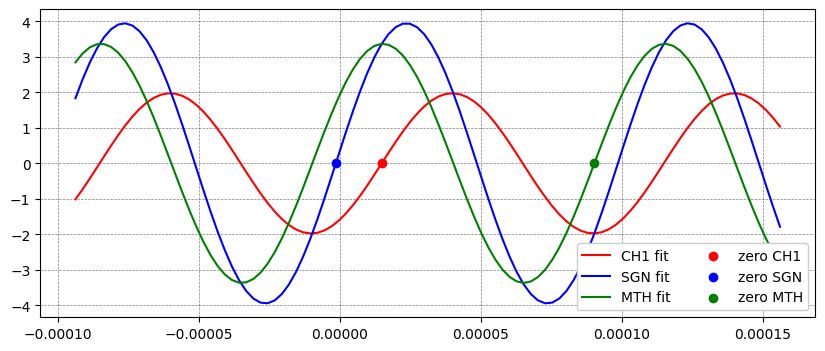

10000 1.6269999999999863e-05 9.166999999999203e-05


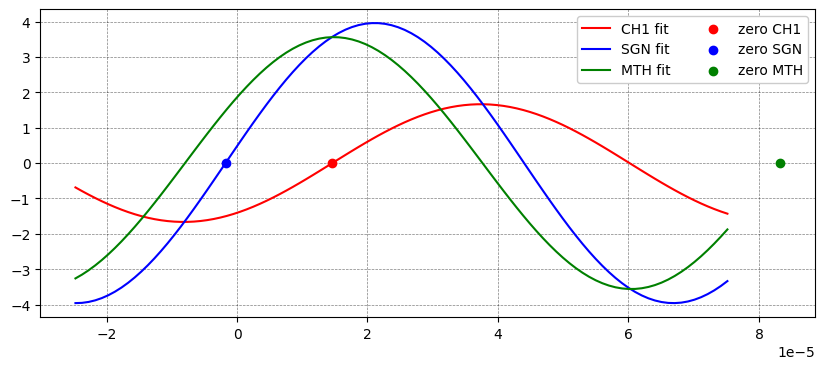

11000 1.6359999999999864e-05 8.496999999999568e-05


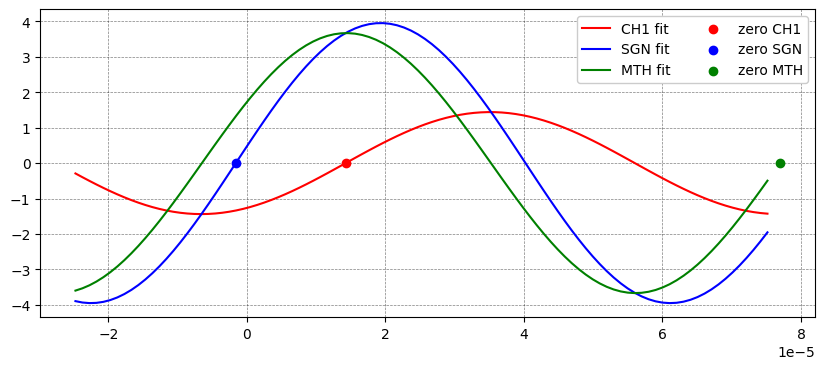

12000 1.5869999999999867e-05 7.856999999999893e-05


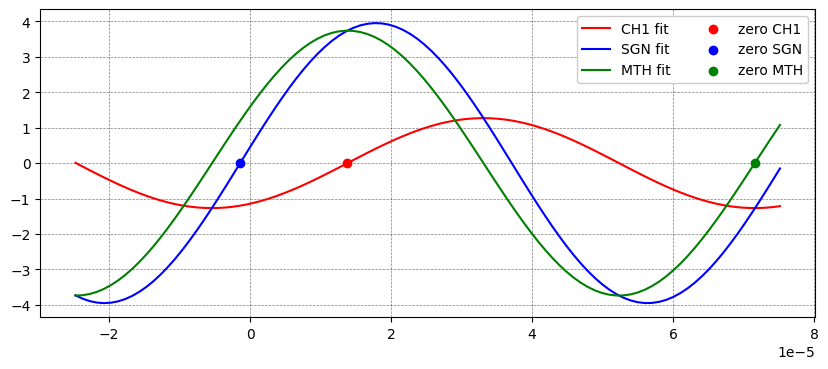

13000 1.5209999999999875e-05 7.298000000000172e-05


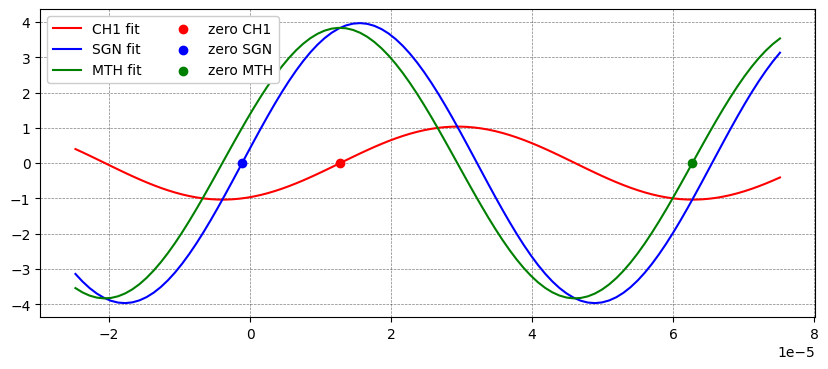

15000 1.3889999999999887e-05 6.385000000000631e-05


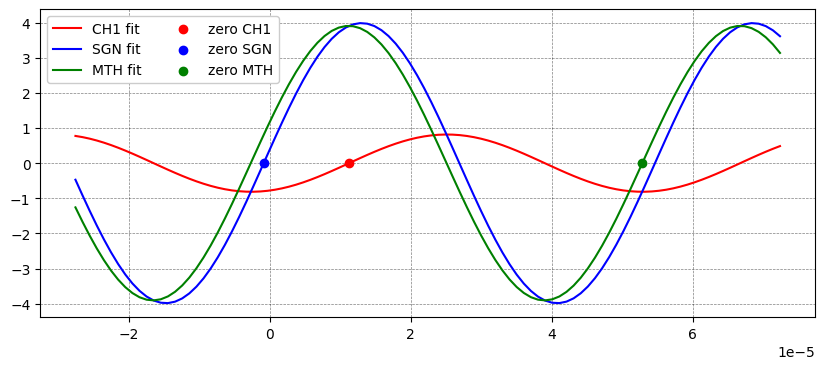

18000 1.2119999999999903e-05 5.370000000000587e-05


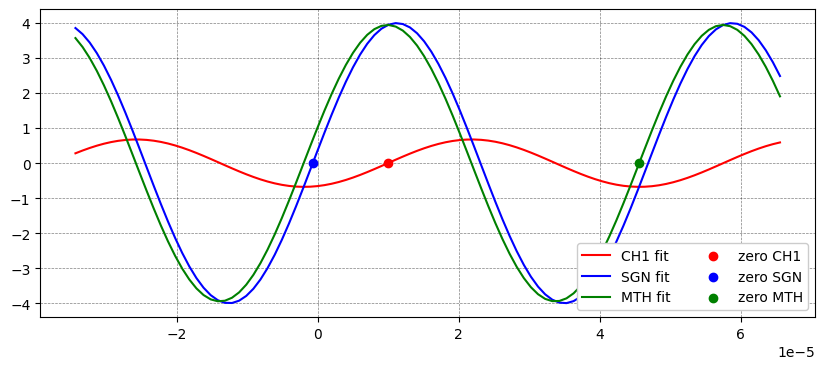

21000 1.0659999999999915e-05 4.6290000000004715e-05


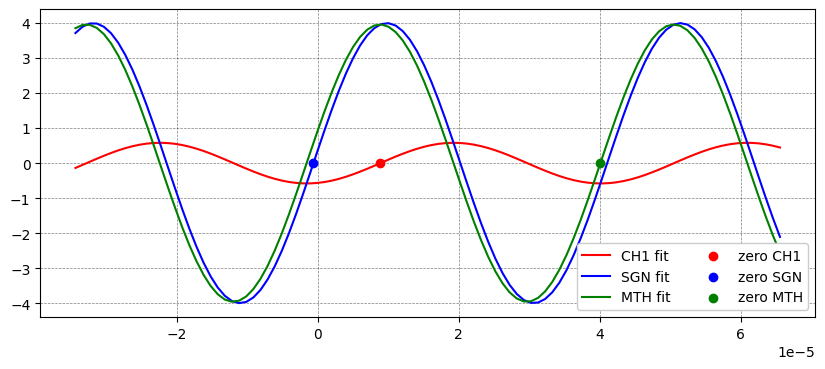

24000 9.489999999999926e-06 4.0690000000003834e-05


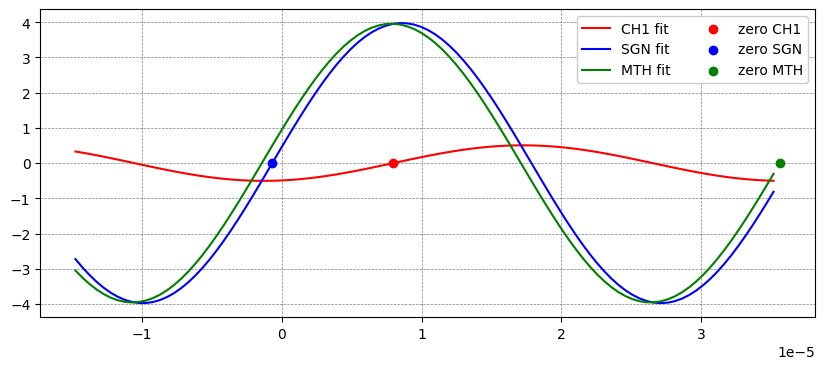

27000 8.659999999999934e-06 3.6330000000003117e-05


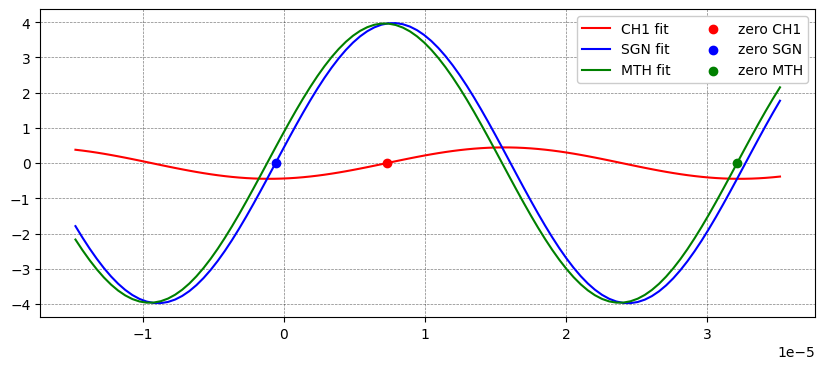

30000 7.889999999999941e-06 3.273000000000256e-05


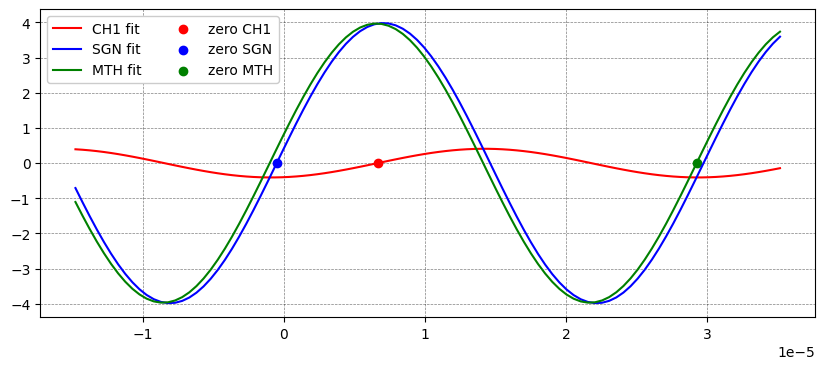

33000 7.159999999999947e-06 2.9770000000002105e-05


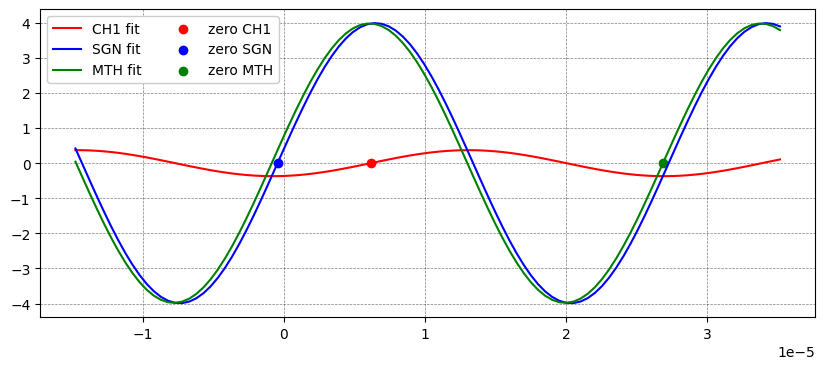

36000 6.599999999999952e-06 2.7330000000001722e-05


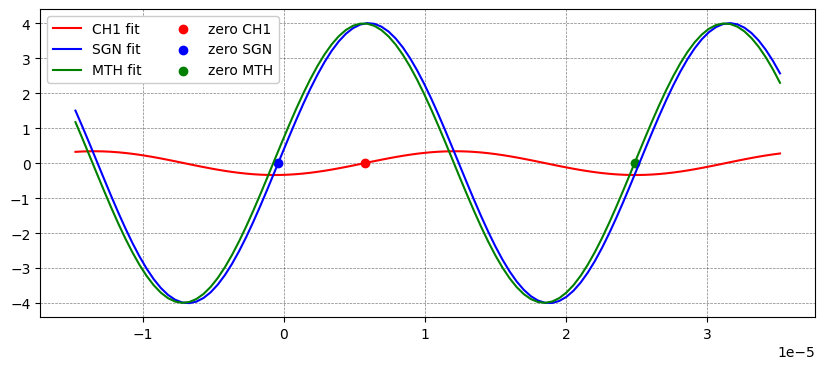

39000 6.129999999999956e-06 2.52700000000014e-05


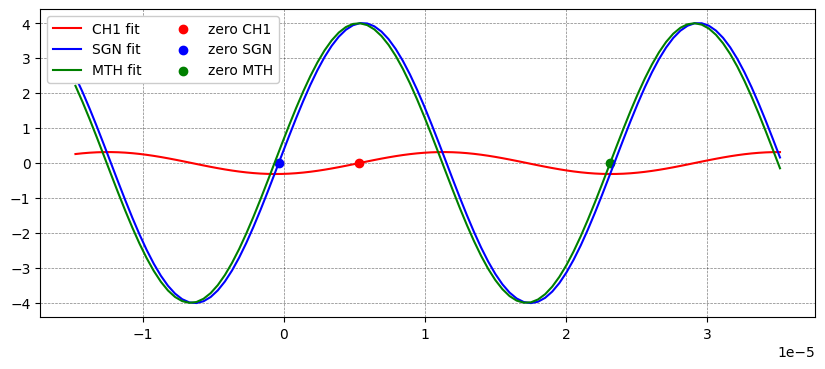

42000 5.719999999999959e-06 2.3500000000001123e-05


In [70]:
if 1:
    path_folder = 'data.leo/RLC_R/'
    V_res, V_l, fase_res, fase_l, freqs, V_res_err, V_l_err = [], [], [], [], [], [], []

    for i in sorted([int(i) for i in os.listdir(path_folder)]):

        path = path_folder+str(i)+'/'

        CH1,SGN,MTH, V_SGN, V_MTH, zero_CH1, zero_SGN, zero_MTH, m1, m2, m3, dt_CH1, dt_MTH, V_SGN_err, V_MTH_err = analize(path, i, force=True, prec=1e-8,verbose=True)
        
        # x=np.linspace(np.min(CH1[0]), np.max(CH1[0]), 100)

        # plt.figure(figsize=(10,4))
        # plt.plot(x, sine(x, **m1.values.to_dict()), label='CH1 fit', color='red')
        # plt.plot(x, sine(x, **m2.values.to_dict()), label='SGN fit', color='blue')
        # plt.plot(x, sine(x, **m3.values.to_dict()), label='MTH fit', color='green')
        
        # # plt.plot(CH1[0], CH1[1], label='CH1', color='red')
        # # plt.plot(SGN[0], SGN[1], label='SGN', color='blue')
        # # plt.plot(MTH[0], MTH[1], label='MTH', color='green')

        # plt.scatter(zero_CH1, 0, color='red', label='zero CH1')
        # plt.scatter(zero_SGN, 0, color='blue', label='zero SGN')
        # plt.scatter(zero_MTH, 0, color='green', label='zero MTH')
        # plt.legend(ncol=2)
        # plt.show()
        # print(i, dt_CH1, dt_MTH)

        V_res.append(V_SGN)
        V_l.append(V_MTH)
        V_res_err.append(V_SGN_err)
        V_l_err.append(V_MTH_err)
        fase_res.append(dt_CH1*i*2*np.pi)
        fase_l.append(dt_MTH*i*2*np.pi)
        freqs.append(i)

    V_res = np.array(V_res)
    V_l = np.array(V_l)
    V_res_err = np.array(V_res_err)
    V_l_err = np.array(V_l_err)
    fase_res = -np.array(fase_res) + np.pi
    fase_l = -np.array(fase_l) + np.pi
    freqs = np.array(freqs)

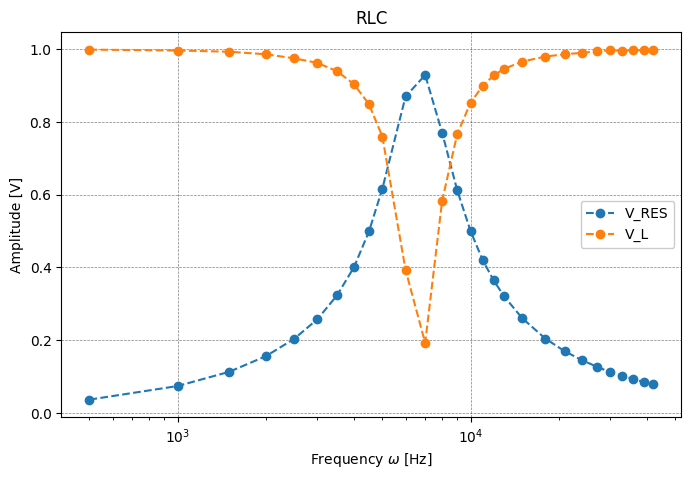

In [62]:
plt.figure(figsize=(8,5))
x = np.linspace(np.min(freqs),np.max(freqs),1000)

# plt.plot(x, H_R(x*2*np.pi, 1e3*12e-9, 0), label='Teorico')
# plt.plot(x, H_C(x*2*np.pi, 1e3*12e-9), label='Teorico')

plt.plot(freqs, V_res, 'o--', label='V_RES')
plt.plot(freqs, V_l, 'o--', label='V_L')
plt.title('RLC')
plt.xlabel('Frequency $\omega$ [Hz]')
plt.ylabel('Amplitude [V]')
plt.legend()
plt.xscale('log')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


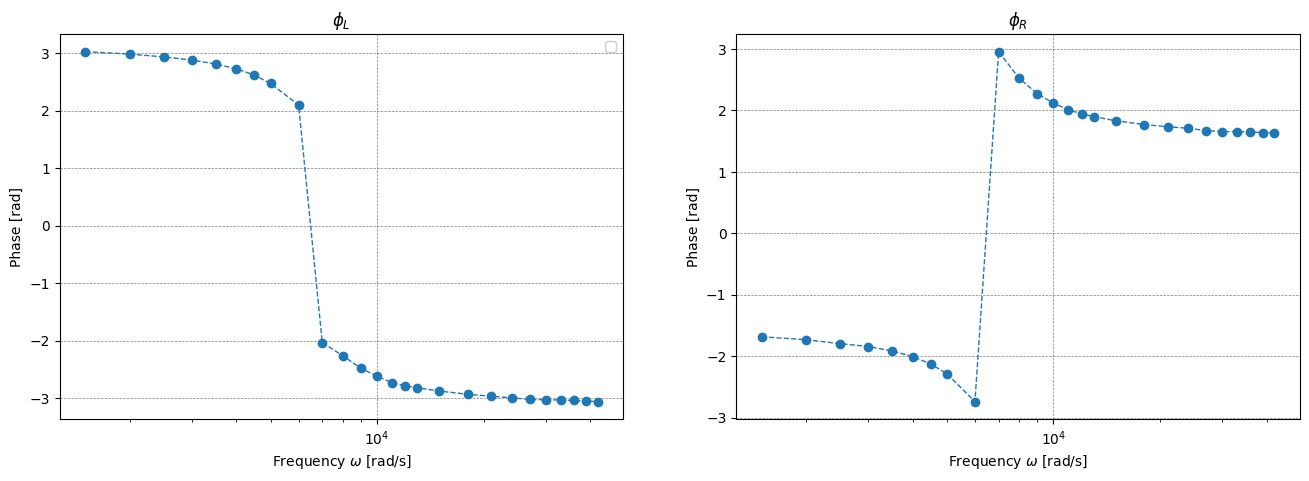

In [63]:
x = np.linspace(np.min(freqs),np.max(freqs),1000)

plt.subplots(1,2,figsize=(16,5))
plt.title('Dati')
plt.subplot(1,2,1)
plt.plot(freqs[2:], fase_l[2:],'o--', lw=1)
plt.title('$\phi_L$')
plt.xlabel('Frequency $\omega$ [rad/s]')
plt.ylabel('Phase [rad]')
plt.legend()
plt.xscale('log')

plt.subplot(1,2,2)
plt.plot(freqs[2:], fase_res[2:], 'o--', lw=1)
# plt.plot(x, fase_C(x*2*np.pi, 1e3, 12e-9, 0), label='Teorico')
# plt.plot(x, fase_R(x*2*np.pi, 1e3, 12e-9), label='Teorico')
plt.title('$\phi_R$')
plt.xlabel('Frequency $\omega$ [rad/s]')
plt.ylabel('Phase [rad]')
plt.xscale('log')

# plt.savefig('imgs/RC/fasi_no_log.jpeg', bbox_inches='tight', dpi=200)
plt.show()

# R

(<Figure size 640x480 with 1 Axes>, <Axes: >)

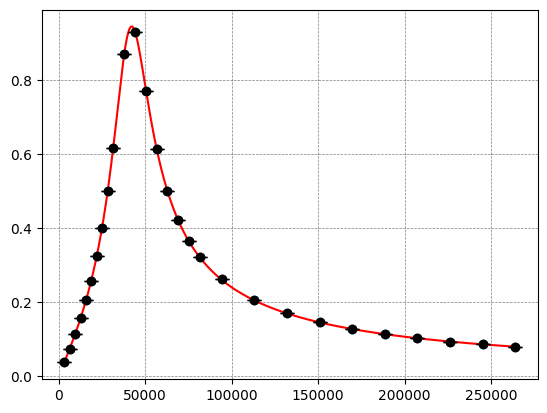

In [39]:
f_m = Fit(freqs*2*np.pi, V_res, G_R, V_res_err, kwargs={'R':1e3, 'R_L':30, 'L':0.04, 'C':12e-9})
f_m.fit()
f_m.visualize()

(<Figure size 640x480 with 1 Axes>, <Axes: >)

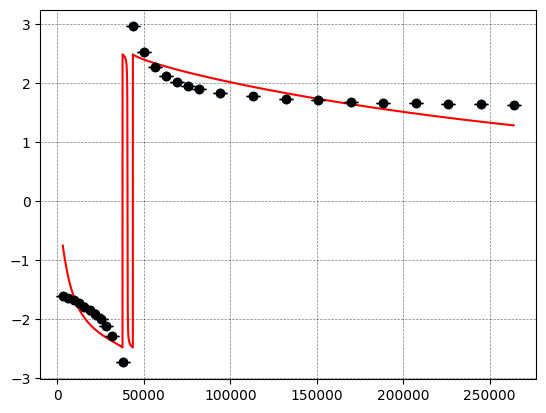

In [69]:
f_f = Fit(freqs*2*np.pi, fase_res, fase, V_res_err, kwargs={'R':1e3, 'R_L':20, 'L':0.04, 'C':12e-9, 'a':1})
f_f.fit()
f_f.visualize(npoints=10000)


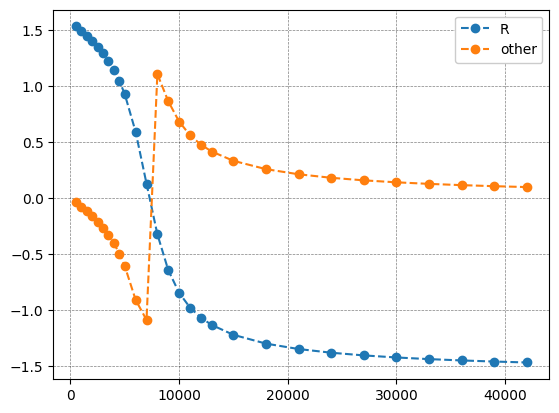

In [60]:
plt.plot(freqs, fase_R(freqs*2*np.pi, 1e3, 50, 0.04, 12e-9), 'o--', label='R')
plt.plot(freqs, fase(freqs*2*np.pi, 1e3, 50, 0.04, 12e-9), 'o--', label='other')
plt.legend()